In [1]:
import os
from google.colab import drive

drive.mount('/content/drive')

os.makedirs('/root/.kaggle', exist_ok=True)

# Copy kaggle.json from your Drive home folder
!cp /content/drive/MyDrive/kaggle.json /root/.kaggle/

!chmod 600 /root/.kaggle/kaggle.json

!kaggle datasets list | head -n 10

Mounted at /content/drive
ref                                                                title                                                     size  lastUpdated                 downloadCount  voteCount  usabilityRating  
-----------------------------------------------------------------  --------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
sadiajavedd/students-academic-performance-dataset                  Students_Academic_Performance_Dataset                     8907  2025-10-23 04:16:35.563000           3897         98  1.0              
ayeshaimran123/social-media-and-mental-health-balance              Social Media and Mental Health Balance                    5941  2025-10-26 07:51:53.380000           4850         67  1.0              
ahmeduzaki/global-earthquake-tsunami-risk-assessment-dataset       Global Earthquake-Tsunami Risk Assessment Dataset        16151  2025-10-01 16:35:53.273000     

In [2]:
# Download the Kaggle dataset and keep only PNGs in default/images
import shutil

from kaggle.api.kaggle_api_extended import KaggleApi

DATASET = "urvishahir/minecraft-block-textures-dataset"
BASE = "default"
IMAGES = os.path.join(BASE, "images")

api = KaggleApi()
api.authenticate()

os.makedirs(BASE, exist_ok=True)
api.dataset_download_files(DATASET, path=BASE, unzip=True)

# Move all .png files into default/images
os.makedirs(IMAGES, exist_ok=True)
for root, _, files in os.walk(BASE):
    if os.path.abspath(root) == os.path.abspath(IMAGES):
        continue
    for fn in files:
        if fn.lower().endswith(".png"):
            src = os.path.join(root, fn)
            dst = os.path.join(IMAGES, fn)
            if os.path.abspath(src) == os.path.abspath(dst):
                continue
            if os.path.exists(dst):
                stem, ext = os.path.splitext(fn)
                i = 1
                while os.path.exists(dst):
                    dst = os.path.join(IMAGES, f"{stem}_{i}{ext}")
                    i += 1
            shutil.move(src, dst)

# Remove everything in default except the images folder
for item in os.listdir(BASE):
    path = os.path.join(BASE, item)
    if os.path.abspath(path) != os.path.abspath(IMAGES):
        if os.path.isdir(path):
            shutil.rmtree(path, ignore_errors=True)
        else:
            os.remove(path)

print(f"Kept {IMAGES}")

Dataset URL: https://www.kaggle.com/datasets/urvishahir/minecraft-block-textures-dataset
Kept default/images


In [3]:
from torch.utils.data import Dataset
from PIL import Image

class MinecraftTextureDataset(Dataset):
    def __init__(self, image_dir, pack_id="default", rgb_background=(128, 128, 128)):
        """
        Args:
            image_dir (str): Directory containing texture PNGs.
            pack_id (str): Name of the texture pack (e.g. 'ashen', 'default', etc.).
            rgb_background (tuple): RGB color to use as background for RGBA textures.
        """
        self.image_dir = image_dir
        self.pack_id = pack_id
        self.rgb_background = rgb_background

        # collect all PNGs
        self.image_files = sorted(
            [f for f in os.listdir(image_dir) if f.lower().endswith(".png")]
        )

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = self.image_files[idx]
        path = os.path.join(self.image_dir, img_name)

        # open image and convert RGBA → RGB using the background
        img = Image.open(path).convert("RGBA")
        bg = Image.new("RGB", img.size, self.rgb_background)
        bg.paste(img, mask=img.split()[3])  # use alpha channel as mask
        image_rgb = bg

        texture_name = os.path.splitext(img_name)[0]

        return {
            "image_rgb": image_rgb,
            "texture_name": texture_name,
            "pack_id": self.pack_id,
        }

In [4]:
# Default dataset
default_dataset = MinecraftTextureDataset("default/images", pack_id="default")

# --- Remove unwanted textures (UI/destroy/overlay junk) ---
bad_textures = {
    "destroy_stage_0",
    "destroy_stage_1",
    "destroy_stage_2",
    "destroy_stage_3",
    "destroy_stage_4",
    "destroy_stage_5",
    "destroy_stage_6",
    "destroy_stage_7",
    "destroy_stage_8",
    "destroy_stage_9",
    "grass_block_side_overlay",
    "redstone_dust_overlay",
    "water_overlay"
}

# Strip file extensions and filter only for default dataset
default_dataset.image_files = [
    f for f in default_dataset.image_files
    if os.path.splitext(f)[0] not in bad_textures
]

# --- Drop non-square textures ---
filtered_files = []
for fname in default_dataset.image_files:
    path = os.path.join(default_dataset.image_dir, fname)
    with Image.open(path) as im:
        w, h = im.size
    if w == h:
        filtered_files.append(fname)

default_dataset.image_files = filtered_files

print(f"Loaded {len(default_dataset)} default textures after filtering")

Loaded 1020 default textures after filtering


Showing 5 samples starting at index 850 from MinecraftTextureDataset

[850] pack_id=default
    texture_name=spruce_trapdoor
    type=<class 'PIL.Image.Image'>, size=(16, 16)



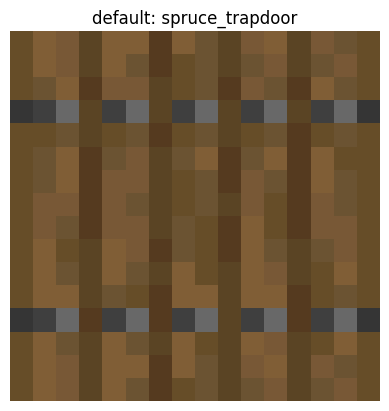

[851] pack_id=default
    texture_name=stone
    type=<class 'PIL.Image.Image'>, size=(16, 16)



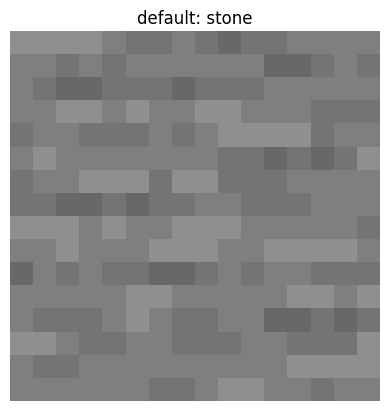

[852] pack_id=default
    texture_name=stone_bricks
    type=<class 'PIL.Image.Image'>, size=(16, 16)



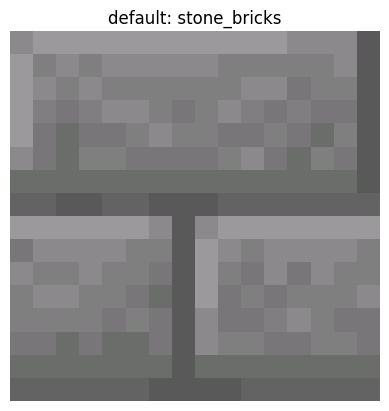

[853] pack_id=default
    texture_name=stonecutter_bottom
    type=<class 'PIL.Image.Image'>, size=(16, 16)



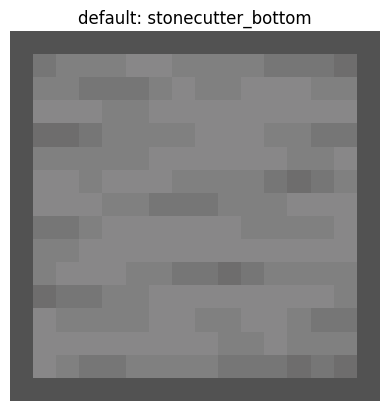

[854] pack_id=default
    texture_name=stonecutter_side
    type=<class 'PIL.Image.Image'>, size=(16, 16)



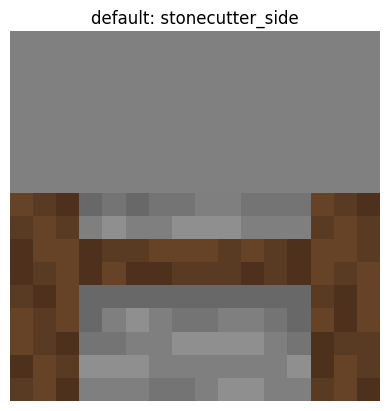

In [5]:
import matplotlib.pyplot as plt

n_samples = 5         # how many samples to show
start_index = 850       # where to start in the dataset
ds = default_dataset

print(f"Showing {n_samples} samples starting at index {start_index} from {ds.__class__.__name__}\n")

for i in range(start_index, start_index + n_samples):
    if i >= len(ds):
        print("Reached end of dataset.")
        break
    sample = ds[i]
    img = sample["image_rgb"]
    tex = sample["texture_name"]
    pack = sample["pack_id"]

    print(f"[{i}] pack_id={pack}")
    print(f"    texture_name={tex}")
    print(f"    type={type(img)}, size={img.size}\n")

    plt.imshow(img)
    plt.title(f"{pack}: {tex}")
    plt.axis("off")
    plt.show()

In [6]:
!pip uninstall -y diffusers
!pip install -U "git+https://github.com/huggingface/diffusers.git"
!pip install -U transformers accelerate datasets safetensors


In [7]:
import torch
from PIL import Image
from diffusers import StableDiffusionImg2ImgPipeline


device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=dtype,
    safety_checker = None
)
pipe = pipe.to(device)


def upscale_for_sd(img_rgb, target_res=512):
    """
    Upscale a Minecraft texture (16x16, 32x32, etc.) to a large resolution
    using nearest-neighbor. This keeps the pixel grid sharp.
    """
    w, h = img_rgb.size
    scale = target_res // w
    scale = max(1, scale)
    new_size = (w * scale, h * scale)
    img_up = img_rgb.resize(new_size, Image.NEAREST)
    return img_up, (w, h)


def downscale_to_orig(img_big, orig_size):
    """
    Downscale the SD output back to the original Minecraft resolution
    using nearest-neighbor.
    """
    return img_big.resize(orig_size, Image.NEAREST)

model_index.json:   0%|          | 0.00/541 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/617 [00:00<?, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/472 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/806 [00:00<?, ?B/s]

text_encoder/model.safetensors:   0%|          | 0.00/492M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/547 [00:00<?, ?B/s]

unet/diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

vae/diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

In [8]:
def gen_sd_baseline(
    sample,
    style_text,
    strength=0.45,
    guidance_scale=7.5,
    seed=10,
    target_res=512,
    return_intermediates=False,
):
    """
    Baseline: default MC texture + text style prompt
    -> SD 1.5 img2img -> downscaled back to original size.
    Optionally returns intermediate images (upscaled input and SD output).
    """

    img_rgb = sample["image_rgb"]
    tex_name = sample["texture_name"]

    # 1. Upscale for SD
    img_up, orig_size = upscale_for_sd(img_rgb, target_res=target_res)

    # 2. Text prompt
    content_prompt = f"{tex_name.replace('_', ' ')} texture"
    prompt = content_prompt + ", " + style_text if style_text else content_prompt

    # 3. Run SD
    generator = torch.Generator(device=device).manual_seed(seed)
    out_big = pipe(
        prompt=prompt,
        image=img_up,
        strength=strength,
        guidance_scale=guidance_scale,
        generator=generator,
        num_inference_steps=30,
    ).images[0]

    # 4. Downscale
    out_small = downscale_to_orig(out_big, orig_size)

    # 5. Reapply alpha if present
    if "image_alpha" in sample:
        alpha = sample["image_alpha"]
        out_small = out_small.convert("RGBA")
        out_small.putalpha(alpha)

    # Return intermediate 512×512 result if requested
    if return_intermediates:
        return out_small, prompt, img_up, out_big

    return out_small, prompt

  0%|          | 0/24 [00:00<?, ?it/s]

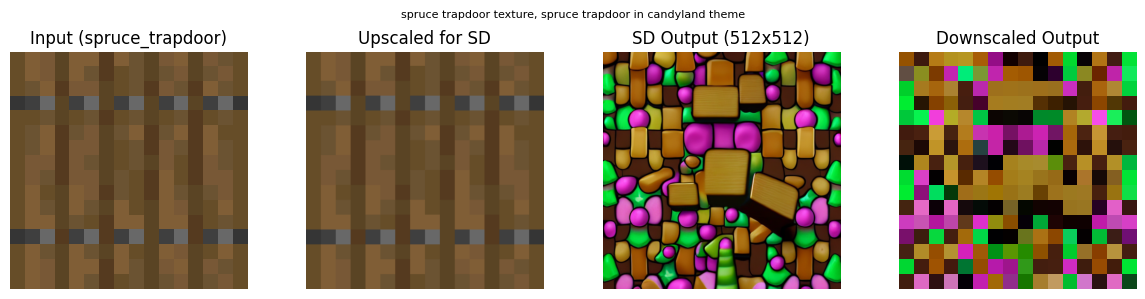

  0%|          | 0/24 [00:00<?, ?it/s]

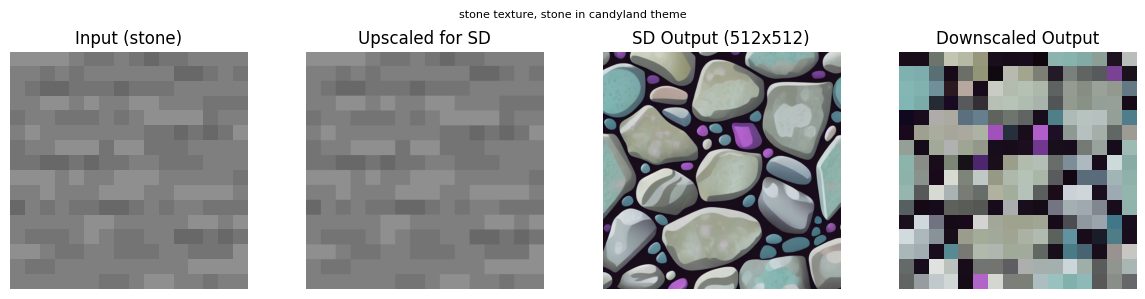

  0%|          | 0/24 [00:00<?, ?it/s]

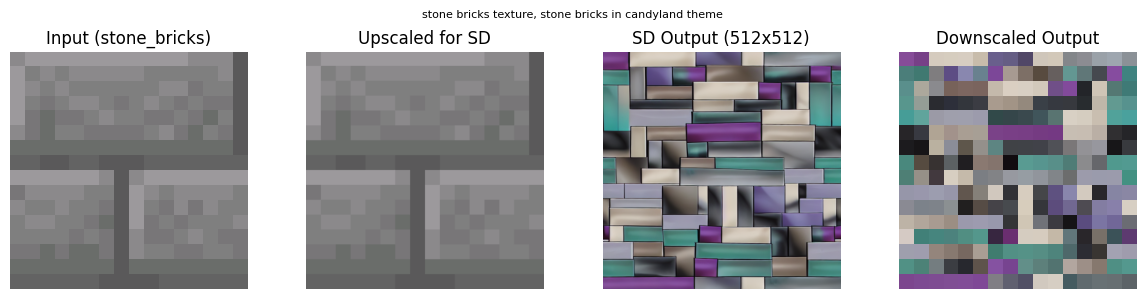

In [9]:
# Inference

example_ids = [850, 851, 852]

for idx in example_ids:
    sample = default_dataset[idx]
    tex_name = sample["texture_name"]

    # style prompt = "<texture name> in candyland theme"
    style_prompt = f"{tex_name.replace('_', ' ')} in candyland theme"

    # Run baseline and get intermediates
    out_img, used_prompt, img_up, out_big = gen_sd_baseline(
        sample,
        style_text=style_prompt,
        strength=0.8,      # how much SD can overwrite the input
        guidance_scale=12,  # how strongly it follows the text
        seed=10,
        target_res=512,
        return_intermediates=True,
    )

    # Display everything for this index
    fig, axes = plt.subplots(1, 4, figsize=(12, 3))

    axes[0].imshow(sample["image_rgb"])
    axes[0].set_title(f"Input ({tex_name})")
    axes[0].axis("off")

    axes[1].imshow(img_up)
    axes[1].set_title("Upscaled for SD")
    axes[1].axis("off")

    axes[2].imshow(out_big)
    axes[2].set_title("SD Output (512x512)")
    axes[2].axis("off")

    axes[3].imshow(out_img)
    axes[3].set_title("Downscaled Output")
    axes[3].axis("off")

    plt.suptitle(used_prompt, fontsize=8)
    plt.tight_layout()
    plt.show()

In [10]:
from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"
dtype = torch.float16 if device == "cuda" else torch.float32

pipe = StableDiffusionImg2ImgPipeline.from_pretrained(
    "runwayml/stable-diffusion-v1-5",
    torch_dtype=dtype,
    safety_checker = None
)
pipe = pipe.to(device)

# ===== load PixelArtRedmond LoRA =====
LORA_REPO = "artificialguybr/pixelartredmond-1-5v-pixel-art-loras-for-sd-1-5"
LORA_FILE = "PixelArtRedmond15V-PixelArt-PIXARFK.safetensors"  # from HF "Files" tab
LORA_SCALE_DEFAULT = 0.8  # starting weight; you can tweak later

pipe.load_lora_weights(
    LORA_REPO,
    weight_name=LORA_FILE,
)

print("Loaded PixelArtRedmond LoRA.")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

PixelArtRedmond15V-PixelArt-PIXARFK.safe(…):   0%|          | 0.00/27.2M [00:00<?, ?B/s]

Loaded PixelArtRedmond LoRA.


In [11]:
def gen_sd_pixel_lora(
    sample,
    style_text,
    strength=0.45,
    guidance_scale=7.5,
    seed=10,
    target_res=512,
    lora_scale=LORA_SCALE_DEFAULT,
    return_intermediates=False,
):

    img_rgb = sample["image_rgb"]
    tex_name = sample["texture_name"]

    # 1. Upscale for SD
    img_up, orig_size = upscale_for_sd(img_rgb, target_res=target_res)

    # 2. Build text prompt
    # Base content: "<texture name> texture"
    content_prompt = f"{tex_name.replace('_', ' ')} texture"

    # Pixel-art trigger words for this LoRA: "pixel art, PixArFK"
    pixel_triggers = "pixel art, PixArFK,"

    # Combine everything: content + style + LoRA triggers
    parts = [content_prompt]
    if style_text:
        parts.append(style_text)
    parts.append(pixel_triggers)
    prompt = ", ".join(parts)

    # 3. Run SD with LoRA scale
    generator = torch.Generator(device=device).manual_seed(seed)
    out_big = pipe(
        prompt=prompt,
        image=img_up,
        strength=strength,          # how much to overwrite the input
        guidance_scale=guidance_scale,  # how strongly to follow the text
        generator=generator,
        num_inference_steps=30,
        cross_attention_kwargs={"scale": lora_scale},  # LoRA strength
    ).images[0]

    # 4. Downscale back to original texture size
    out_small = downscale_to_orig(out_big, orig_size)

    # 5. Reapply alpha if present
    if "image_alpha" in sample:
        alpha = sample["image_alpha"]
        out_small = out_small.convert("RGBA")
        out_small.putalpha(alpha)

    if return_intermediates:
        return out_small, prompt, img_up, out_big

    return out_small, prompt

PixelArt LoRA img2img on index 850: spruce_trapdoor (LoRA scale=0.3)


  0%|          | 0/24 [00:00<?, ?it/s]

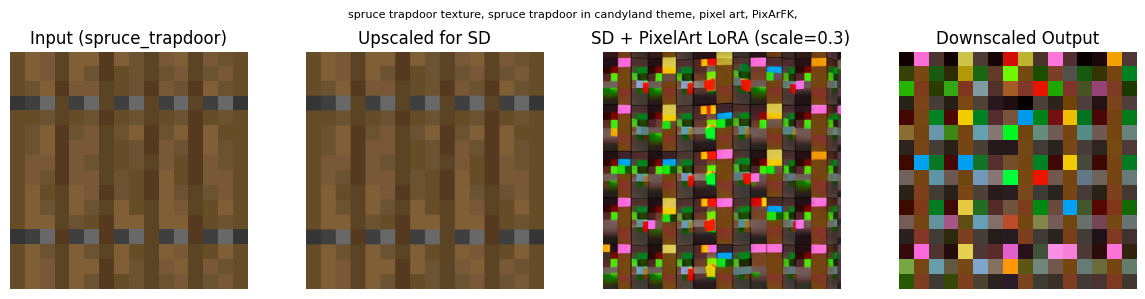

PixelArt LoRA img2img on index 850: spruce_trapdoor (LoRA scale=0.7)


  0%|          | 0/24 [00:00<?, ?it/s]

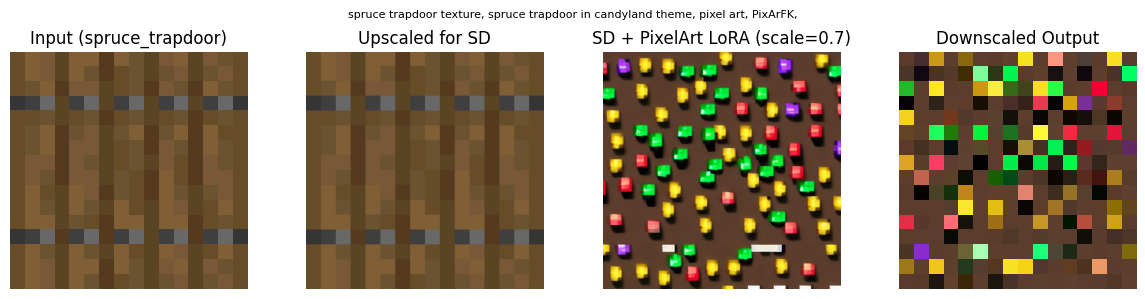

PixelArt LoRA img2img on index 850: spruce_trapdoor (LoRA scale=1.0)


  0%|          | 0/24 [00:00<?, ?it/s]

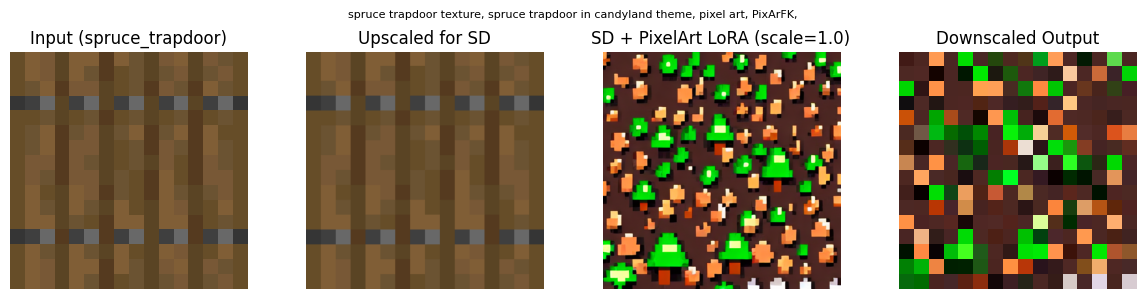

PixelArt LoRA img2img on index 851: stone (LoRA scale=0.3)


  0%|          | 0/24 [00:00<?, ?it/s]

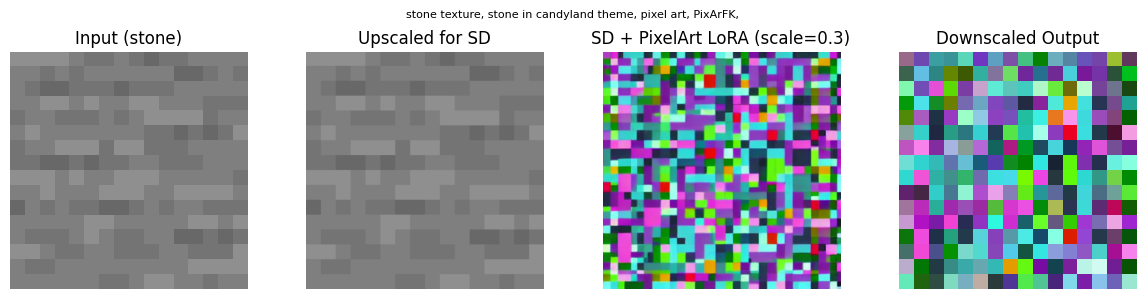

PixelArt LoRA img2img on index 851: stone (LoRA scale=0.7)


  0%|          | 0/24 [00:00<?, ?it/s]

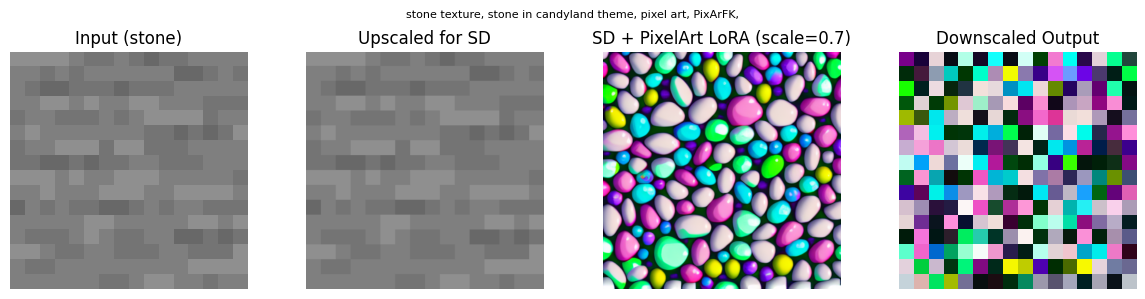

PixelArt LoRA img2img on index 851: stone (LoRA scale=1.0)


  0%|          | 0/24 [00:00<?, ?it/s]

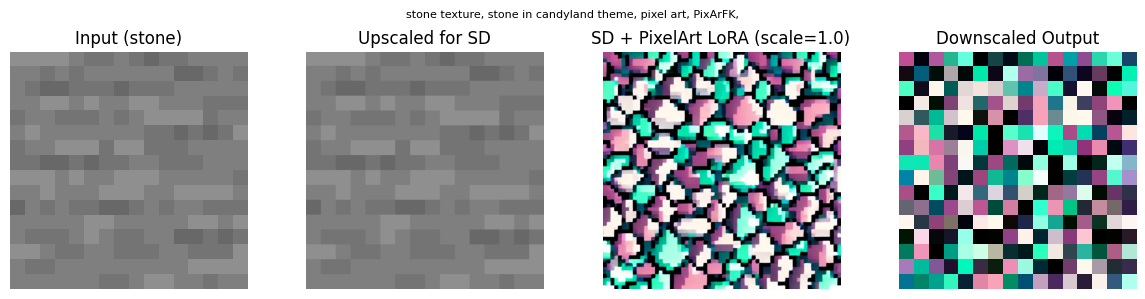

PixelArt LoRA img2img on index 852: stone_bricks (LoRA scale=0.3)


  0%|          | 0/24 [00:00<?, ?it/s]

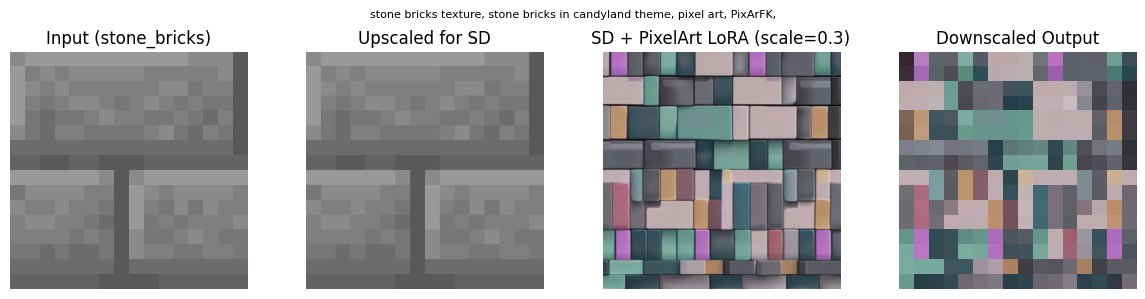

PixelArt LoRA img2img on index 852: stone_bricks (LoRA scale=0.7)


  0%|          | 0/24 [00:00<?, ?it/s]

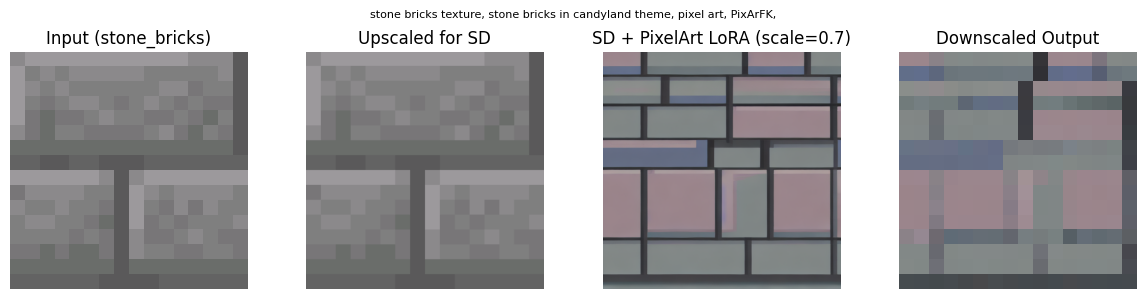

PixelArt LoRA img2img on index 852: stone_bricks (LoRA scale=1.0)


  0%|          | 0/24 [00:00<?, ?it/s]

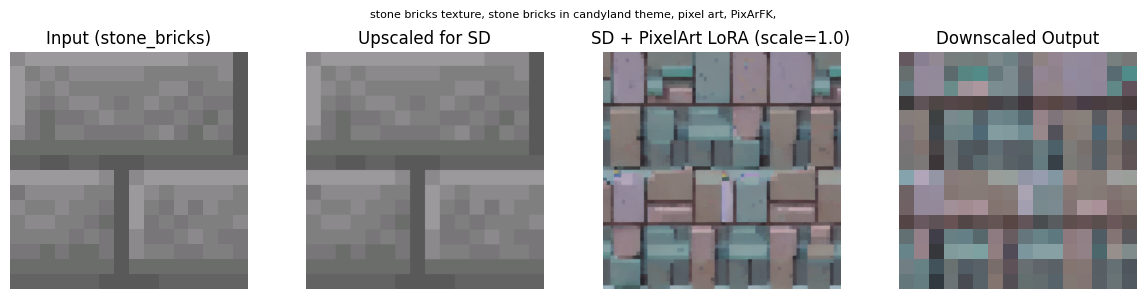

In [12]:
# PixelArt LoRA img2img: compare different LoRA strengths

example_ids = [850, 851, 852]
lora_scales = [0.3, 0.7, 1.0]

for idx in example_ids:
    sample = default_dataset[idx]
    tex_name = sample["texture_name"]

    style_prompt = f"{tex_name.replace('_', ' ')} in candyland theme"

    for lora_scale in lora_scales:
        print(f"PixelArt LoRA img2img on index {idx}: {tex_name} (LoRA scale={lora_scale})")

        out_img, used_prompt, img_up, out_big = gen_sd_pixel_lora(
            sample,
            style_text=style_prompt,
            strength=0.8,
            guidance_scale=12,  # how strongly it follows the text
            seed=42,
            target_res=512,
            lora_scale=lora_scale,
            return_intermediates=True,
        )

        fig, axes = plt.subplots(1, 4, figsize=(12, 3))

        axes[0].imshow(sample["image_rgb"])
        axes[0].set_title(f"Input ({tex_name})")
        axes[0].axis("off")

        axes[1].imshow(img_up)
        axes[1].set_title("Upscaled for SD")
        axes[1].axis("off")

        axes[2].imshow(out_big)
        axes[2].set_title(f"SD + PixelArt LoRA (scale={lora_scale})")
        axes[2].axis("off")

        axes[3].imshow(out_img)
        axes[3].set_title("Downscaled Output")
        axes[3].axis("off")

        plt.suptitle(used_prompt, fontsize=8)
        plt.tight_layout()
        plt.show()

In [13]:
import json
from pathlib import Path
import numpy as np
from tqdm.auto import tqdm

# Where to export training images + metadata for LoRA
TRAIN_DIR = "/content/mc_default_lora_train"
os.makedirs(TRAIN_DIR, exist_ok=True)

metadata_path = os.path.join(TRAIN_DIR, "metadata.jsonl")

num_items = len(default_dataset)
print("Exporting", num_items, "textures to", TRAIN_DIR)

with open(metadata_path, "w") as f:
    for idx, sample in tqdm(enumerate(default_dataset), total=num_items):
        img = sample["image_rgb"]
        tex_name = sample["texture_name"]

        # Ensure PIL.Image
        if isinstance(img, np.ndarray):
            img = Image.fromarray(img)
        img = img.convert("RGB")

        # Save as 6-digit PNG
        file_name = f"{idx:06d}.png"
        img.save(os.path.join(TRAIN_DIR, file_name))

        # Trigger caption used for training
        clean_name = tex_name.replace("_", " ")
        caption = f"minecraft texture of {clean_name}"

        # metadata.jsonl: file_name + text (default caption column)
        rec = {"file_name": file_name, "text": caption}
        f.write(json.dumps(rec) + "\n")

print("Wrote metadata to", metadata_path)

Exporting 1020 textures to /content/mc_default_lora_train


  0%|          | 0/1020 [00:00<?, ?it/s]

Wrote metadata to /content/mc_default_lora_train/metadata.jsonl


In [14]:
!wget -O train_text_to_image_lora_sd15.py \
  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora.py


In [15]:
# SD 1.5 base
MODEL_NAME  = "runwayml/stable-diffusion-v1-5"

TRAIN_DIR   = "/content/mc_default_lora_train"           # same training data folder
OUTPUT_DIR  = "/content/mc_default_lora_sd15_r32"        # NEW SD1.5 LoRA output dir

os.environ["MODEL_NAME"]  = MODEL_NAME
os.environ["TRAIN_DIR"]   = TRAIN_DIR
os.environ["OUTPUT_DIR"]  = OUTPUT_DIR

print("Model:", MODEL_NAME)
print("Train dir:", TRAIN_DIR)
print("Output dir:", OUTPUT_DIR)

Model: runwayml/stable-diffusion-v1-5
Train dir: /content/mc_default_lora_train
Output dir: /content/mc_default_lora_sd15_r32


In [16]:
!accelerate launch train_text_to_image_lora_sd15.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --train_data_dir=$TRAIN_DIR \
  --resolution=512 \
  --center_crop \
  --random_flip \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=10000 \
  --checkpointing_steps=1000 \
  --mixed_precision="fp16" \
  --seed=10 \
  --rank=32 \
  --output_dir=$OUTPUT_DIR
# We use rank 32 since intuition says a bigger capacity for small model


In [17]:
from diffusers import StableDiffusionImg2ImgPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

BASE_MODEL_ID   = "runwayml/stable-diffusion-v1-5"
LORA_OUTPUT_DIR = "/content/mc_default_lora_sd15_r32"

pipe_lora = StableDiffusionImg2ImgPipeline.from_pretrained(
    BASE_MODEL_ID,
    use_safetensors=True,
    safety_checker = None
).to(device)

pipe_lora.load_lora_weights(LORA_OUTPUT_DIR)

# force correct dtype everywhere:
pipe_lora.to(device=device, dtype=torch.float32)
pipe_lora.unet.to(device=device, dtype=torch.float32)
pipe_lora.vae.to(device=device, dtype=torch.float32)
pipe_lora.text_encoder.to(device=device, dtype=torch.float32)

print("unet dtype:", next(pipe_lora.unet.parameters()).dtype)
print("vae  dtype:", next(pipe_lora.vae.parameters()).dtype)
print("te   dtype:", next(pipe_lora.text_encoder.parameters()).dtype)

print("SD1.5 LoRA pipeline ready (fp32).")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

unet dtype: torch.float32
vae  dtype: torch.float32
te   dtype: torch.float32
SD1.5 LoRA pipeline ready (fp32).


In [18]:
def gen_sd15_mc_lora(
    sample,
    style_text,
    strength=0.8,
    guidance_scale=12.0,
    seed=10,
    target_res=512,
    lora_scale=0.8,
    num_inference_steps=30,
    return_intermediates=False,
):
    """
    SD 1.5 img2img + Minecraft-default LoRA (rank 32).
    """

    img_rgb = sample["image_rgb"]
    tex_name = sample["texture_name"]

    img_up, orig_size = upscale_for_sd(img_rgb, target_res=target_res)

    clean_name = tex_name.replace("_", " ")
    base_prompt = f"minecraft texture of {clean_name}"

    parts = [base_prompt]
    if style_text:
        parts.append(style_text)
    prompt = ", ".join(parts)

    generator = torch.Generator(device=device).manual_seed(seed)

    out_big = pipe_lora(
        prompt=prompt,
        image=img_up,
        strength=strength,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=generator,
        cross_attention_kwargs={"scale": lora_scale},
    ).images[0]

    out_small = downscale_to_orig(out_big, orig_size)

    if "image_alpha" in sample:
        alpha = sample["image_alpha"]
        out_small = out_small.convert("RGBA")
        out_small.putalpha(alpha)

    if return_intermediates:
        return out_small, prompt, img_up, out_big

    return out_small

SD1.5 Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

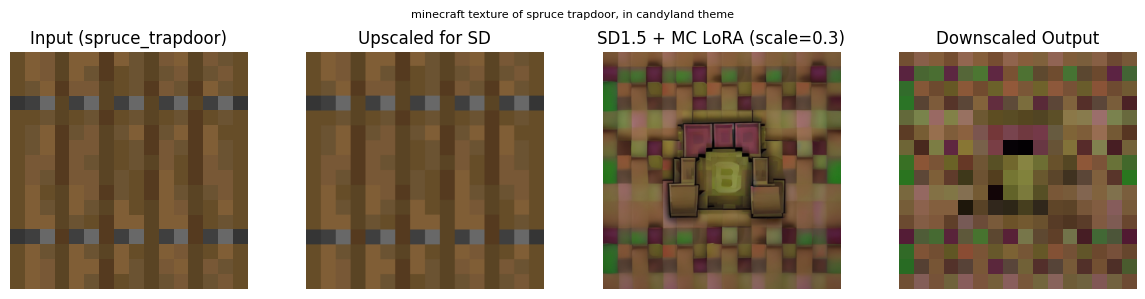

SD1.5 Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

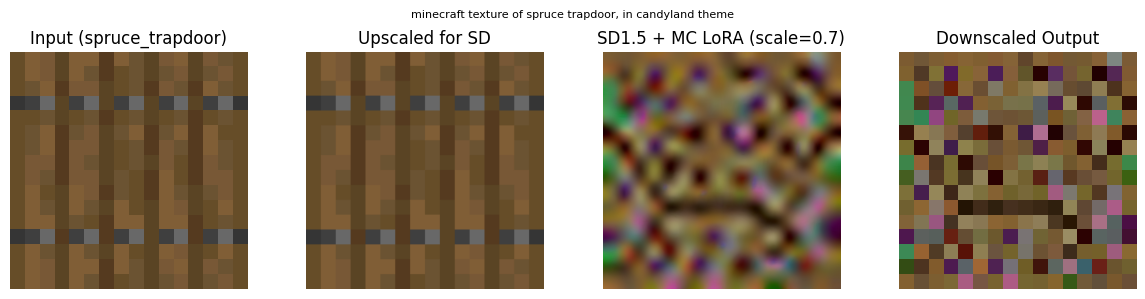

SD1.5 Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

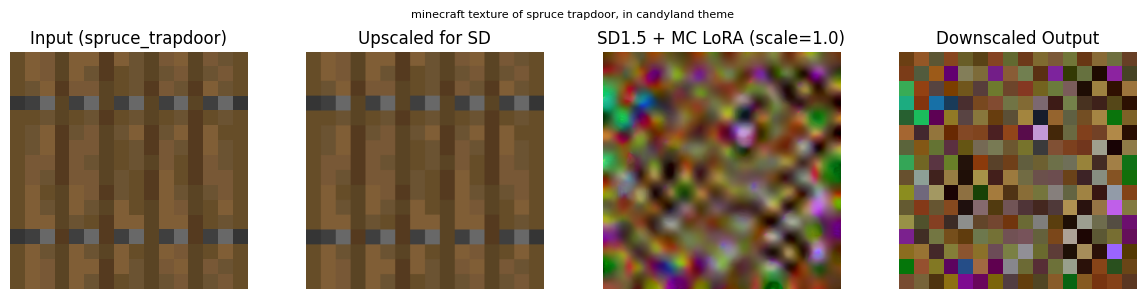

SD1.5 Minecraft LoRA img2img on index 851: stone (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

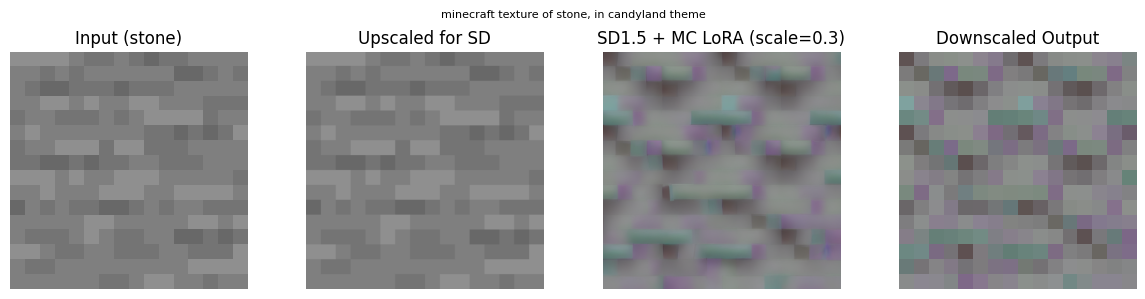

SD1.5 Minecraft LoRA img2img on index 851: stone (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

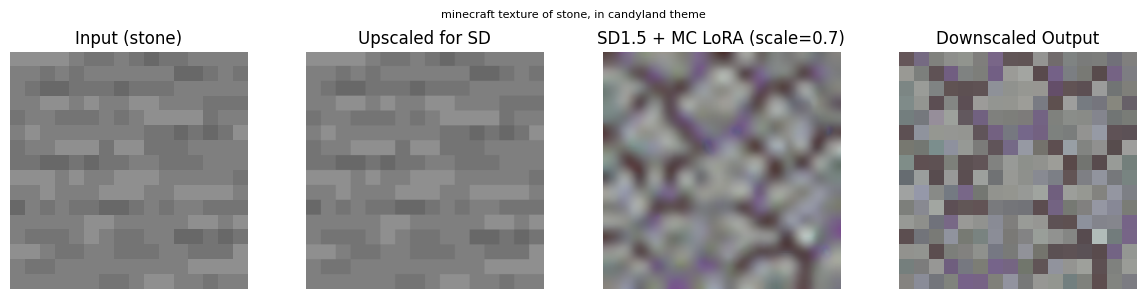

SD1.5 Minecraft LoRA img2img on index 851: stone (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

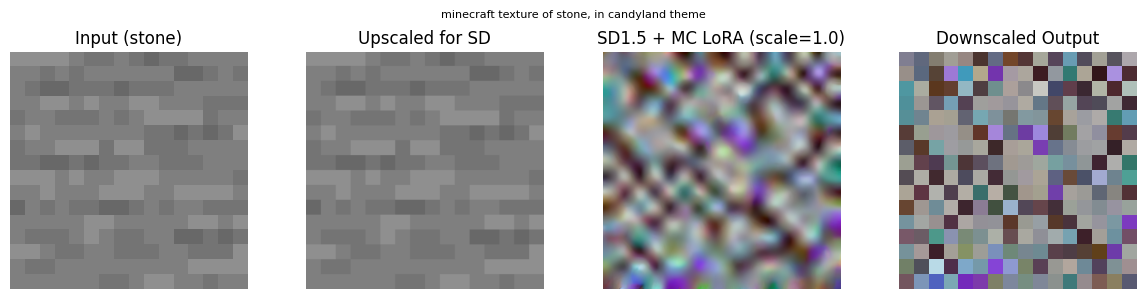

SD1.5 Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

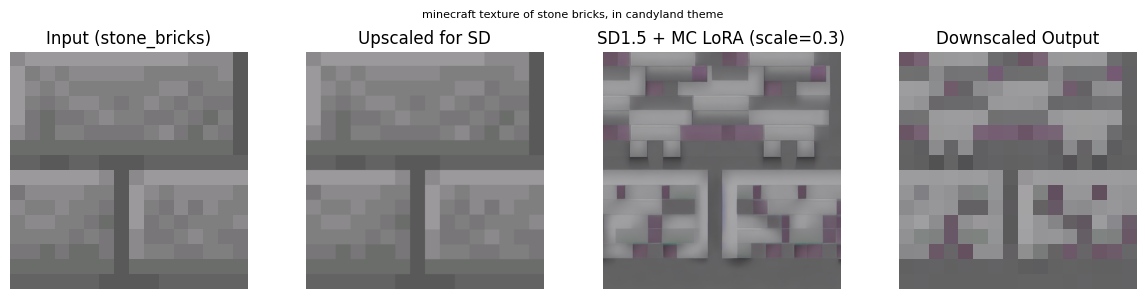

SD1.5 Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

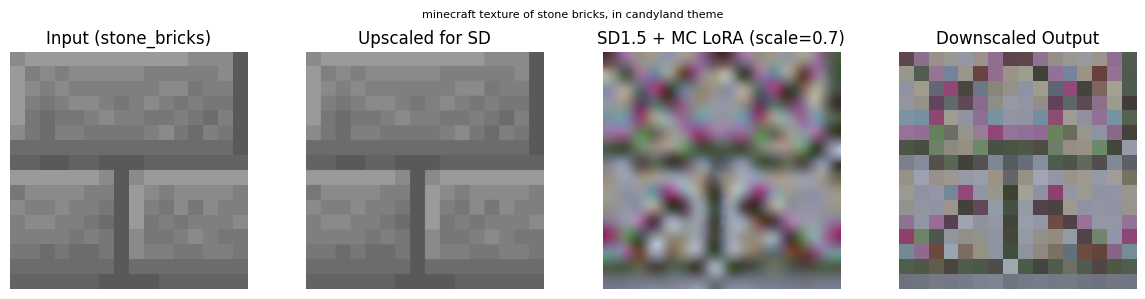

SD1.5 Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

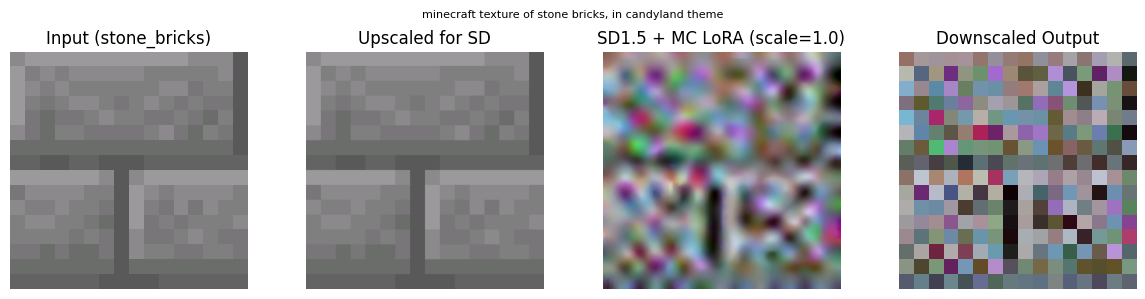

In [19]:
# Minecraft SD1.5 LoRA img2img: compare different LoRA strengths

example_ids = [850, 851, 852]
lora_scales = [0.3, 0.7, 1.0]

for idx in example_ids:
    sample = default_dataset[idx]
    tex_name = sample["texture_name"]
    clean = tex_name.replace("_", " ")

    style_suffix = "in candyland theme"

    for lora_scale in lora_scales:
        print(f"SD1.5 Minecraft LoRA img2img on index {idx}: {tex_name} (LoRA scale={lora_scale})")

        out_img, used_prompt, img_up, out_big = gen_sd15_mc_lora(
            sample,
            style_text=style_suffix,
            strength=0.7,   # how much SD+LoRA can overwrite the input
            guidance_scale=8,
            seed=10,
            target_res=512,
            lora_scale=lora_scale,
            return_intermediates=True,
        )

        fig, axes = plt.subplots(1, 4, figsize=(12, 3))

        axes[0].imshow(sample["image_rgb"])
        axes[0].set_title(f"Input ({tex_name})")
        axes[0].axis("off")

        axes[1].imshow(img_up)
        axes[1].set_title("Upscaled for SD")
        axes[1].axis("off")

        axes[2].imshow(out_big)
        axes[2].set_title(f"SD1.5 + MC LoRA (scale={lora_scale})")
        axes[2].axis("off")

        axes[3].imshow(out_img)
        axes[3].set_title("Downscaled Output")
        axes[3].axis("off")

        plt.suptitle(used_prompt, fontsize=8)
        plt.tight_layout()
        plt.show()


In [20]:
from diffusers import StableDiffusionPipeline
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_MODEL_ID   = "runwayml/stable-diffusion-v1-5"
LORA_OUTPUT_DIR = "/content/mc_default_lora_sd15_r32"

pipe_txt = StableDiffusionPipeline.from_pretrained(
    BASE_MODEL_ID,
    use_safetensors=True,
    safety_checker = None
).to(device)

pipe_txt.load_lora_weights(LORA_OUTPUT_DIR)

pipe_txt.to(device=device, dtype=torch.float32)
pipe_txt.unet.to(device=device, dtype=torch.float32)
pipe_txt.vae.to(device=device, dtype=torch.float32)
pipe_txt.text_encoder.to(device=device, dtype=torch.float32)

print("dtypes:",
      next(pipe_txt.unet.parameters()).dtype,
      next(pipe_txt.vae.parameters()).dtype,
      next(pipe_txt.text_encoder.parameters()).dtype)

pipe_txt.enable_vae_tiling()

print("SD1.5 text2img LoRA pipeline ready (fp32).")

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

dtypes: torch.float32 torch.float32 torch.float32
SD1.5 text2img LoRA pipeline ready (fp32).



Generating T2I for: spruce_trapdoor
Prompt: minecraft texture of spruce trapdoor


  0%|          | 0/30 [00:00<?, ?it/s]

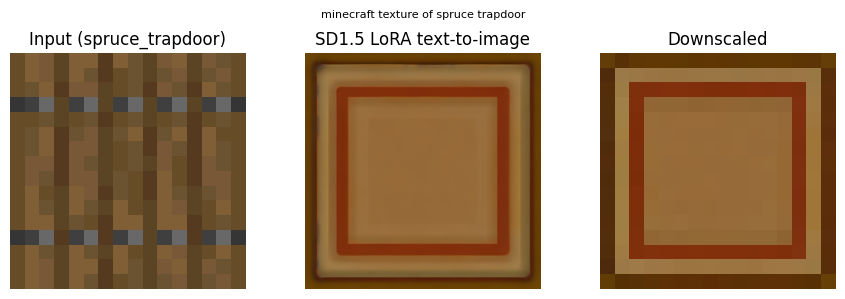


Generating T2I for: stone
Prompt: minecraft texture of stone


  0%|          | 0/30 [00:00<?, ?it/s]

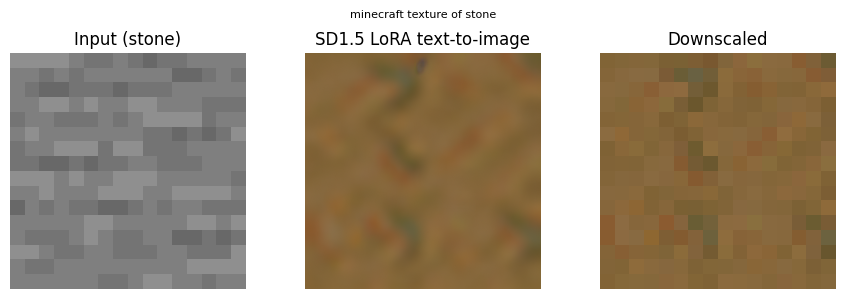


Generating T2I for: stone_bricks
Prompt: minecraft texture of stone bricks


  0%|          | 0/30 [00:00<?, ?it/s]

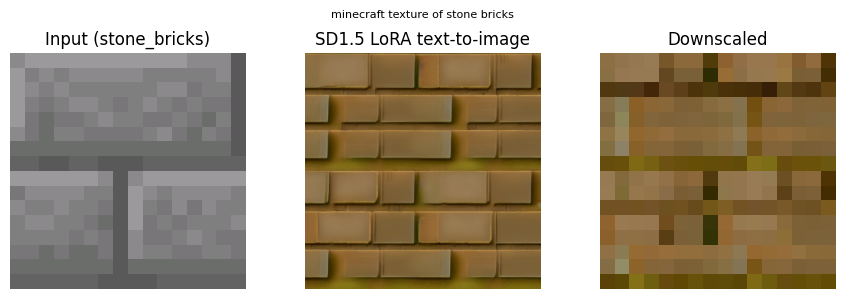

In [21]:
# Text-to-image sanity check with LoRA

example_ids = [850, 851, 852]
guidance_scale = 8
num_steps = 30
style_suffix = ""

for idx in example_ids:
    sample   = default_dataset[idx]
    tex_name = sample["texture_name"]
    clean    = tex_name.replace("_", " ")

    prompt = f"minecraft texture of {clean}"
    if style_suffix:
        prompt += f", {style_suffix}"

    print("\nGenerating T2I for:", tex_name)
    print("Prompt:", prompt)

    generator = torch.Generator(device=device).manual_seed(10)

    out_img = pipe_txt(
        prompt=prompt,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        generator=generator,
        cross_attention_kwargs={"scale": 0.5},
    ).images[0]

    orig_img = sample["image_rgb"]
    out_small = out_img.resize(orig_img.size, resample=Image.NEAREST)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(orig_img)
    axes[0].set_title(f"Input ({tex_name})")
    axes[0].axis("off")

    axes[1].imshow(out_img)
    axes[1].set_title("SD1.5 LoRA text-to-image")
    axes[1].axis("off")

    axes[2].imshow(out_small)
    axes[2].set_title("Downscaled")
    axes[2].axis("off")

    plt.suptitle(prompt, fontsize=8)
    plt.tight_layout()
    plt.show()

In [22]:
!wget -O train_text_to_image_lora_sdxl.py \
  https://raw.githubusercontent.com/huggingface/diffusers/main/examples/text_to_image/train_text_to_image_lora_sdxl.py


In [23]:
import os

# SDXL base 1.0
MODEL_NAME  = "stabilityai/stable-diffusion-xl-base-1.0"

TRAIN_DIR   = "/content/mc_default_lora_train"          # same train data
OUTPUT_DIR  = "/content/mc_default_lora_sdxl_r4"        # new folder for SDXL LoRA

os.environ["MODEL_NAME"]  = MODEL_NAME
os.environ["TRAIN_DIR"]   = TRAIN_DIR
os.environ["OUTPUT_DIR"]  = OUTPUT_DIR

print("Model:", MODEL_NAME)
print("Train dir:", TRAIN_DIR)
print("Output dir:", OUTPUT_DIR)

Model: stabilityai/stable-diffusion-xl-base-1.0
Train dir: /content/mc_default_lora_train
Output dir: /content/mc_default_lora_sdxl_r4


In [24]:
!accelerate launch train_text_to_image_lora_sdxl.py \
  --pretrained_model_name_or_path=$MODEL_NAME \
  --train_data_dir=$TRAIN_DIR \
  --resolution=512 \
  --center_crop \
  --random_flip \
  --train_batch_size=2 \
  --gradient_accumulation_steps=2 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=10000 \
  --checkpointing_steps=1000 \
  --mixed_precision="fp16" \
  --seed=42 \
  --rank=4 \
  --output_dir=$OUTPUT_DIR


In [25]:
from diffusers import StableDiffusionXLImg2ImgPipeline

device = "cuda" if torch.cuda.is_available() else "cpu"

BASE_MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"

pipe_lora = StableDiffusionXLImg2ImgPipeline.from_pretrained(
    BASE_MODEL_ID,
    use_safetensors=True,
    safety_checker = None
).to(device)

# Load LoRA weights from Drive
pipe_lora.load_lora_weights(
    LORA_DIR,
    weight_name=LORA_NAME,
)

# Force fp32 everywhere
pipe_lora.to(device=device, dtype=torch.float32)
pipe_lora.unet.to(device=device, dtype=torch.float32)
pipe_lora.vae.to(device=device, dtype=torch.float32)
pipe_lora.text_encoder.to(device=device, dtype=torch.float32)
pipe_lora.text_encoder_2.to(device=device, dtype=torch.float32)

print("unet dtype:", next(pipe_lora.unet.parameters()).dtype)
print("vae  dtype:", next(pipe_lora.vae.parameters()).dtype)
print("te1  dtype:", next(pipe_lora.text_encoder.parameters()).dtype)
print("te2  dtype:", next(pipe_lora.text_encoder_2.parameters()).dtype)

print("SDXL LoRA img2img pipeline ready (fp32).")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

unet dtype: torch.float32
vae  dtype: torch.float32
te1  dtype: torch.float32
te2  dtype: torch.float32
SDXL LoRA img2img pipeline ready (fp32).


In [26]:
def gen_sdxl_mc_lora(
    sample,
    style_text,
    strength=0.8,
    guidance_scale=12.0,
    seed=10,
    target_res=512,
    lora_scale=0.8,
    num_inference_steps=30,
    return_intermediates=False,
):
    """
    SDXL img2img + Minecraft-default LoRA (rank 4).
    """

    img_rgb = sample["image_rgb"]
    tex_name = sample["texture_name"]

    # 1. Upscale for SDXL
    img_up, orig_size = upscale_for_sd(img_rgb, target_res=target_res)

    # 2. Build text prompt
    clean_name = tex_name.replace("_", " ")
    content_prompt = f"minecraft texture of {clean_name}"

    parts = [content_prompt]
    if style_text:
        parts.append(style_text)

    prompt = ", ".join(parts)

    # 3. Run SDXL + LoRA
    generator = torch.Generator(device=device).manual_seed(seed)

    out_big = pipe_lora(
        prompt=prompt,
        image=img_up,
        strength=strength,
        guidance_scale=guidance_scale,
        num_inference_steps=num_inference_steps,
        generator=generator,
        cross_attention_kwargs={"scale": lora_scale},
    ).images[0]

    # 4. Downscale to original size
    out_small = downscale_to_orig(out_big, orig_size)

    # 5. Reapply alpha if present
    if "image_alpha" in sample:
        alpha = sample["image_alpha"]
        out_small = out_small.convert("RGBA")
        out_small.putalpha(alpha)

    if return_intermediates:
        return out_small, prompt, img_up, out_big

    return out_small

SDXL Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

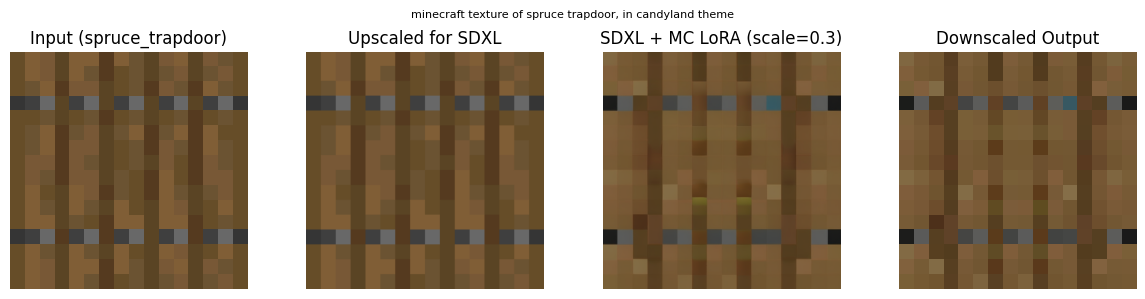

SDXL Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

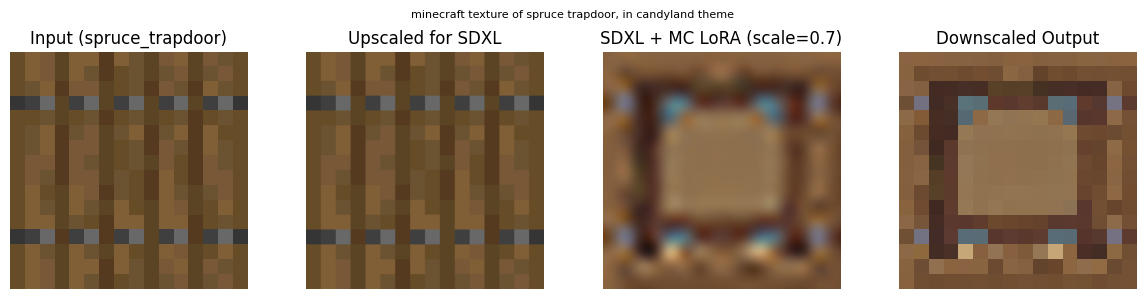

SDXL Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

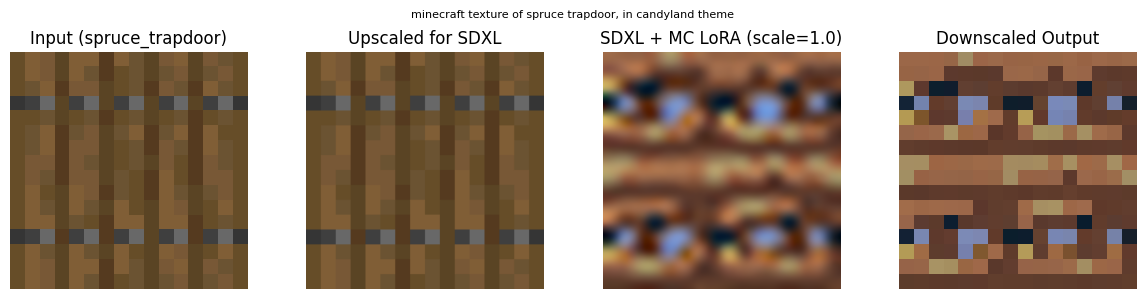

SDXL Minecraft LoRA img2img on index 851: stone (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

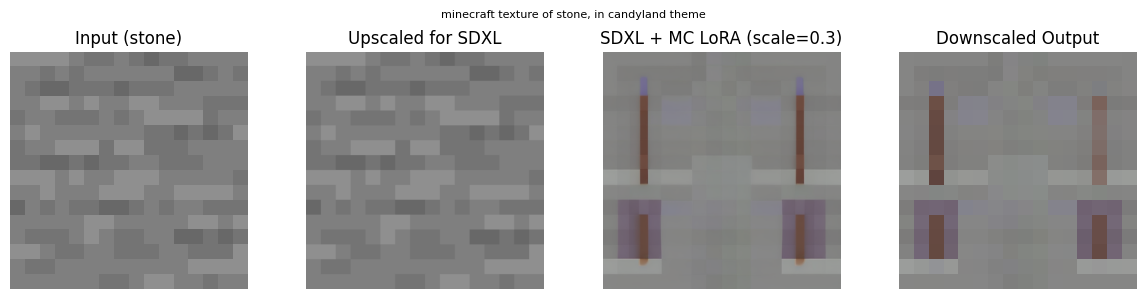

SDXL Minecraft LoRA img2img on index 851: stone (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

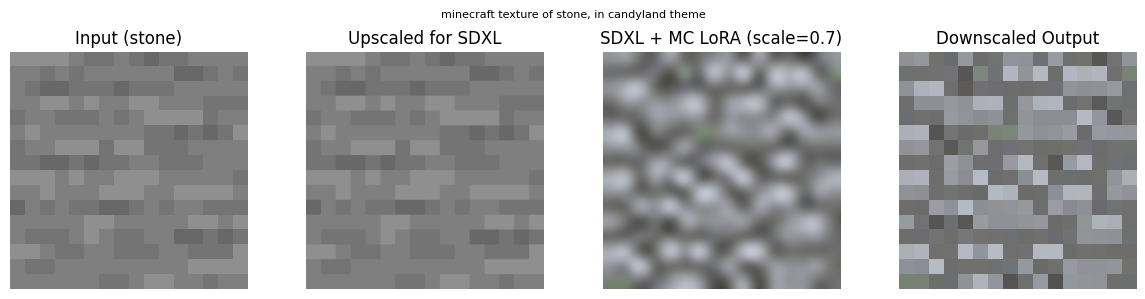

SDXL Minecraft LoRA img2img on index 851: stone (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

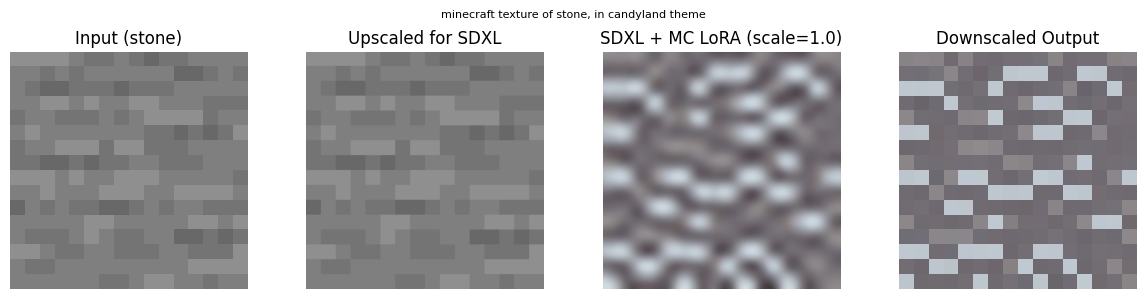

SDXL Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

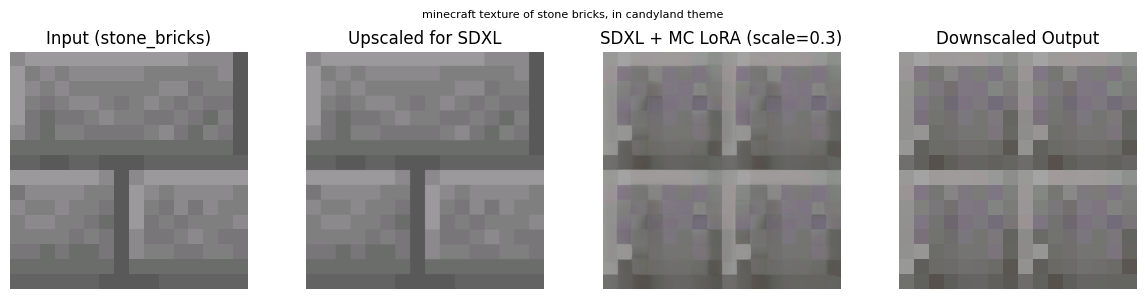

SDXL Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

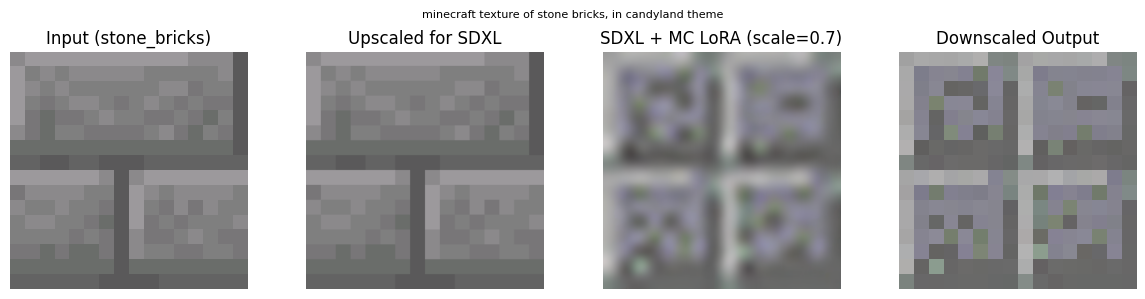

SDXL Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

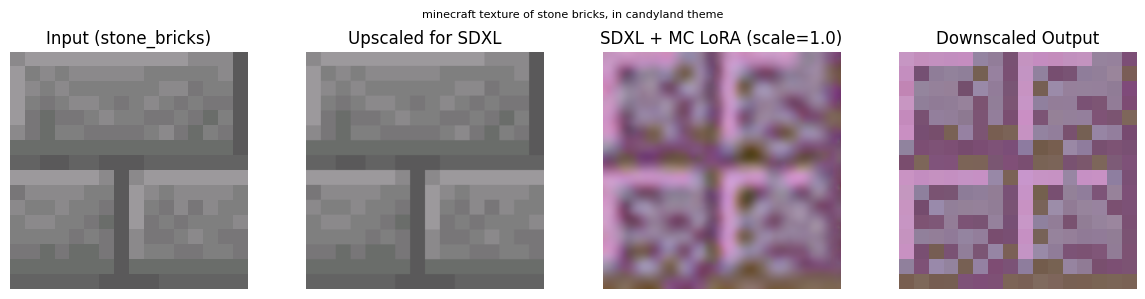

In [27]:
# Minecraft SDXL LoRA img2img: compare different LoRA strengths

example_ids = [850, 851, 852]
lora_scales = [0.3, 0.7, 1.0]

for idx in example_ids:
    sample = default_dataset[idx]
    tex_name = sample["texture_name"]
    clean = tex_name.replace("_", " ")

    style_suffix = "in candyland theme"

    for lora_scale in lora_scales:
        print(f"SDXL Minecraft LoRA img2img on index {idx}: {tex_name} (LoRA scale={lora_scale})")

        out_img, used_prompt, img_up, out_big = gen_sdxl_mc_lora(
            sample,
            style_text=style_suffix,
            strength=0.7,
            guidance_scale=8,
            seed=42,  # i recall some other settings on seed 42
            target_res=512,
            lora_scale=lora_scale,
            return_intermediates=True,
        )

        fig, axes = plt.subplots(1, 4, figsize=(12, 3))

        axes[0].imshow(sample["image_rgb"])
        axes[0].set_title(f"Input ({tex_name})")
        axes[0].axis("off")

        axes[1].imshow(img_up)
        axes[1].set_title("Upscaled for SDXL")
        axes[1].axis("off")

        axes[2].imshow(out_big)
        axes[2].set_title(f"SDXL + MC LoRA (scale={lora_scale})")
        axes[2].axis("off")

        axes[3].imshow(out_img)
        axes[3].set_title("Downscaled Output")
        axes[3].axis("off")

        plt.suptitle(used_prompt, fontsize=8)
        plt.tight_layout()
        plt.show()

SDXL Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

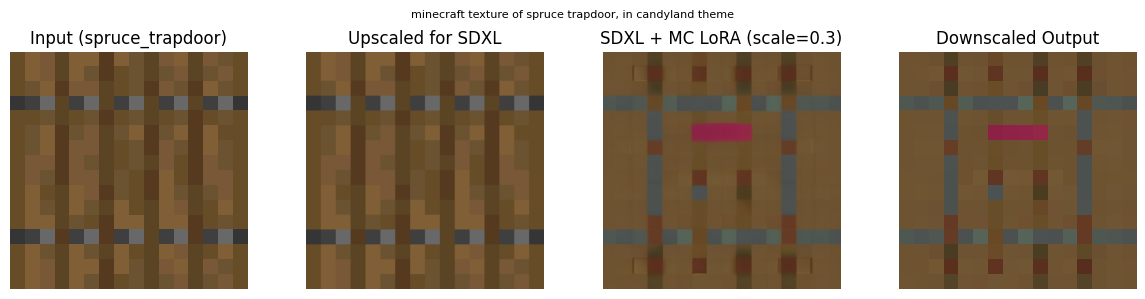

SDXL Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

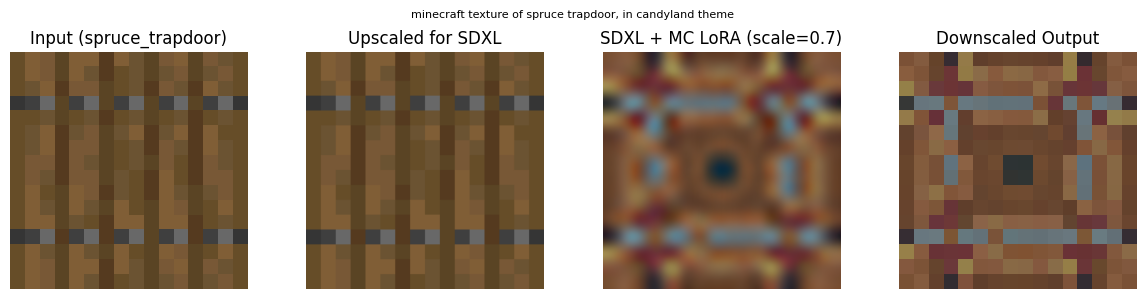

SDXL Minecraft LoRA img2img on index 850: spruce_trapdoor (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

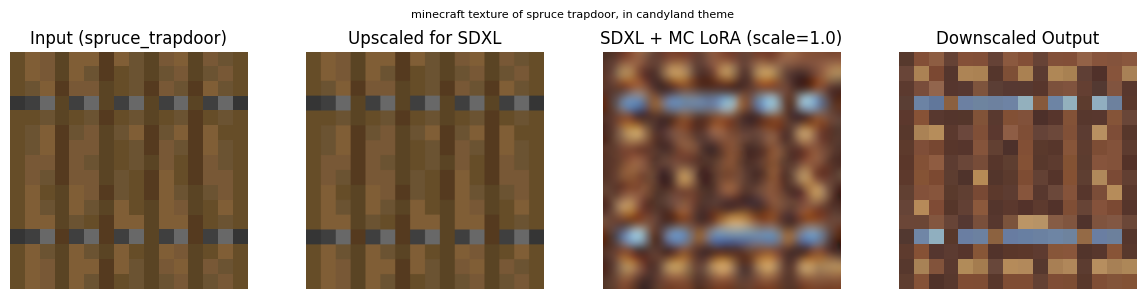

SDXL Minecraft LoRA img2img on index 851: stone (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

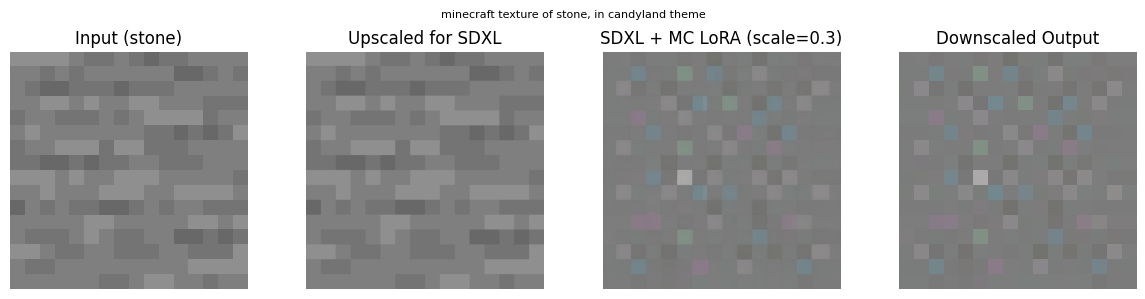

SDXL Minecraft LoRA img2img on index 851: stone (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

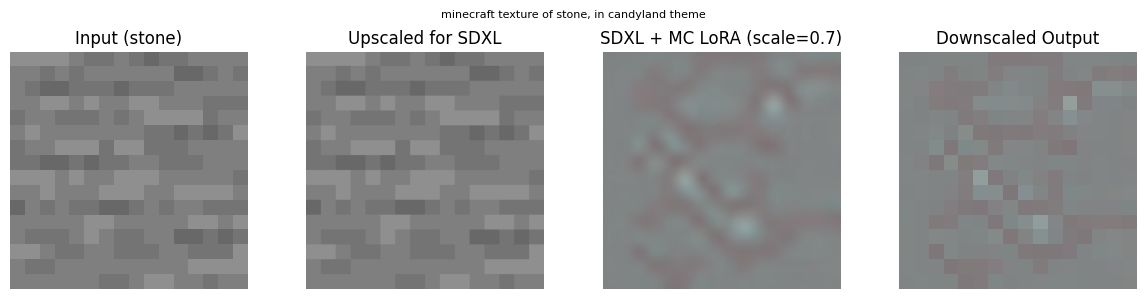

SDXL Minecraft LoRA img2img on index 851: stone (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

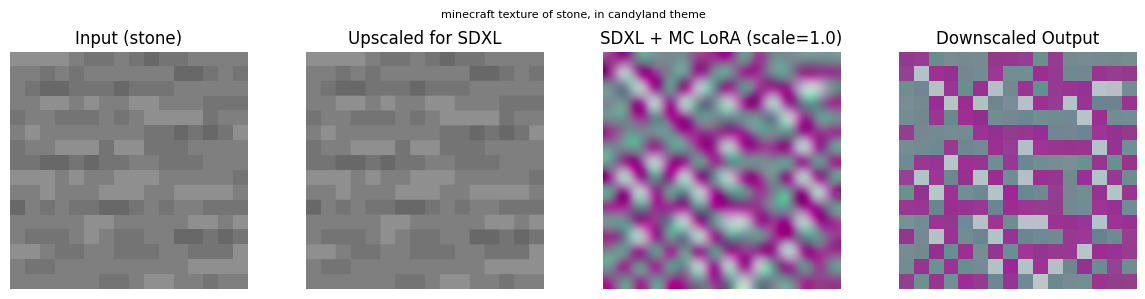

SDXL Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=0.3)


  0%|          | 0/21 [00:00<?, ?it/s]

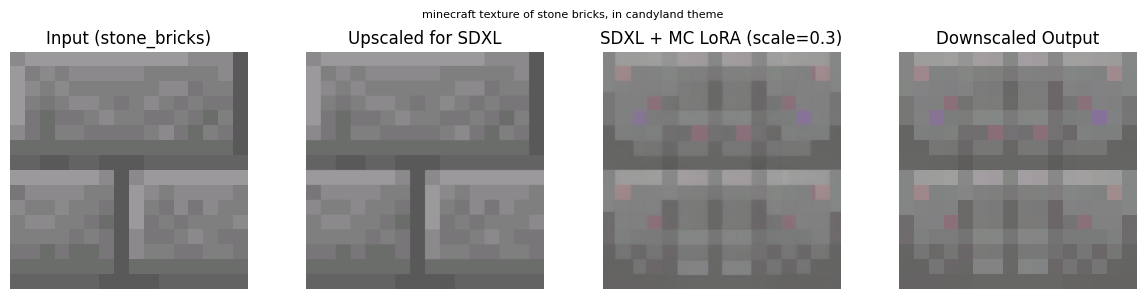

SDXL Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=0.7)


  0%|          | 0/21 [00:00<?, ?it/s]

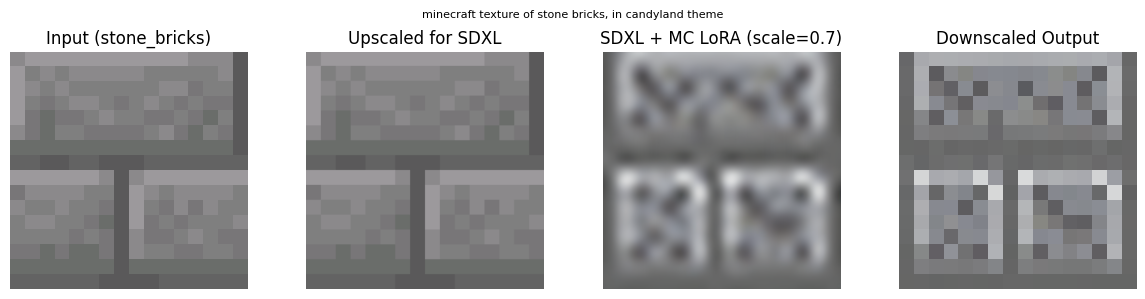

SDXL Minecraft LoRA img2img on index 852: stone_bricks (LoRA scale=1.0)


  0%|          | 0/21 [00:00<?, ?it/s]

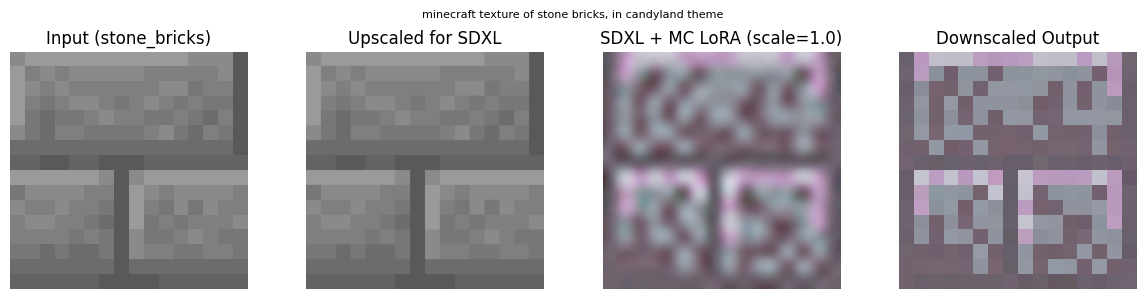

In [28]:
# Minecraft SDXL LoRA img2img: compare different LoRA strengths

example_ids = [850, 851, 852]
lora_scales = [0.3, 0.7, 1.0]

for idx in example_ids:
    sample = default_dataset[idx]
    tex_name = sample["texture_name"]
    clean = tex_name.replace("_", " ")

    style_suffix = "in candyland theme"

    for lora_scale in lora_scales:
        print(f"SDXL Minecraft LoRA img2img on index {idx}: {tex_name} (LoRA scale={lora_scale})")

        out_img, used_prompt, img_up, out_big = gen_sdxl_mc_lora(
            sample,
            style_text=style_suffix,
            strength=0.7,
            guidance_scale=8,
            seed=10,
            target_res=512,
            lora_scale=lora_scale,
            return_intermediates=True,
        )

        fig, axes = plt.subplots(1, 4, figsize=(12, 3))

        axes[0].imshow(sample["image_rgb"])
        axes[0].set_title(f"Input ({tex_name})")
        axes[0].axis("off")

        axes[1].imshow(img_up)
        axes[1].set_title("Upscaled for SDXL")
        axes[1].axis("off")

        axes[2].imshow(out_big)
        axes[2].set_title(f"SDXL + MC LoRA (scale={lora_scale})")
        axes[2].axis("off")

        axes[3].imshow(out_img)
        axes[3].set_title("Downscaled Output")
        axes[3].axis("off")

        plt.suptitle(used_prompt, fontsize=8)
        plt.tight_layout()
        plt.show()

In [29]:
from diffusers import StableDiffusionXLPipeline
from PIL import Image

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

BASE_MODEL_ID = "stabilityai/stable-diffusion-xl-base-1.0"

pipe_txt = StableDiffusionXLPipeline.from_pretrained(
    BASE_MODEL_ID,
    use_safetensors=True,
).to(device)

# Load LoRA from Drive
pipe_txt.load_lora_weights(
    LORA_DIR,
    weight_name=LORA_NAME,
)

# fp32 everywhere
pipe_txt.to(device=device, dtype=torch.float32)
pipe_txt.unet.to(device=device, dtype=torch.float32)
pipe_txt.vae.to(device=device, dtype=torch.float32)
pipe_txt.text_encoder.to(device=device, dtype=torch.float32)
pipe_txt.text_encoder_2.to(device=device, dtype=torch.float32)

print("unet dtype:", next(pipe_txt.unet.parameters()).dtype)
print("vae  dtype:", next(pipe_txt.vae.parameters()).dtype)
print("te1  dtype:", next(pipe_txt.text_encoder.parameters()).dtype)
print("te2  dtype:", next(pipe_txt.text_encoder_2.parameters()).dtype)

pipe_txt.enable_vae_tiling()
try:
    pipe_txt.enable_xformers_memory_efficient_attention()
except Exception as e:
    print("xformers not enabled:", e)

print("SDXL text2img pipeline ready (fp32).")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

unet dtype: torch.float32
vae  dtype: torch.float32
te1  dtype: torch.float32
te2  dtype: torch.float32
xformers not enabled: Refer to https://github.com/facebookresearch/xformers for more information on how to install xformers
SDXL text2img pipeline ready (fp32).



Generating text-to-image for: spruce_trapdoor
Prompt: minecraft texture of spruce trapdoor


  0%|          | 0/30 [00:00<?, ?it/s]

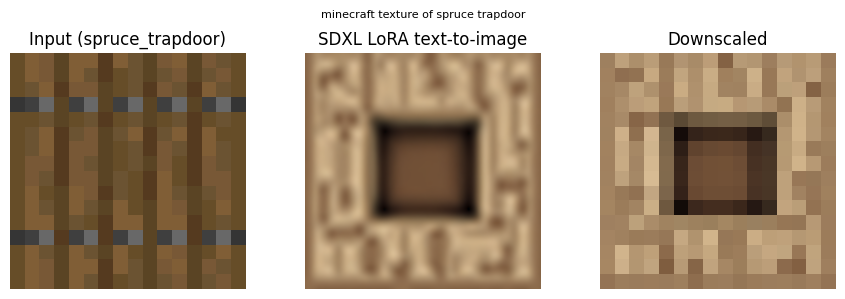


Generating text-to-image for: stone
Prompt: minecraft texture of stone


  0%|          | 0/30 [00:00<?, ?it/s]

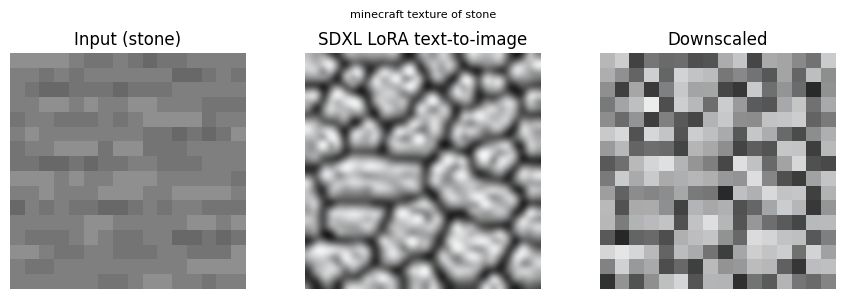


Generating text-to-image for: stone_bricks
Prompt: minecraft texture of stone bricks


  0%|          | 0/30 [00:00<?, ?it/s]

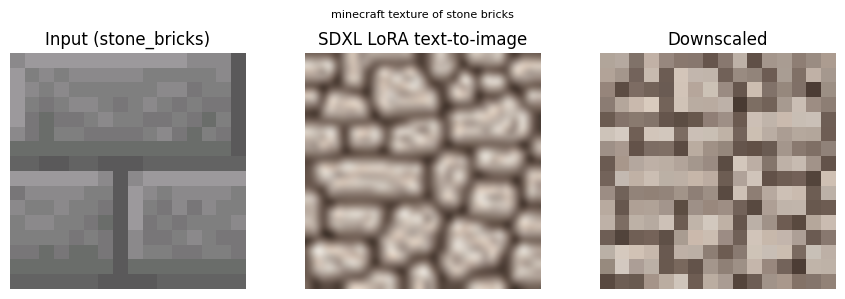

In [30]:
# SDXL LoRA text-to-image sanity check

example_ids = [850, 851, 852]
guidance_scale = 8
num_steps = 30
style_suffix = ""

for idx in example_ids:
    sample   = default_dataset[idx]
    tex_name = sample["texture_name"]
    clean    = tex_name.replace("_", " ")

    prompt = f"minecraft texture of {clean}"
    if style_suffix:
        prompt += f", {style_suffix}"

    print("\nGenerating text-to-image for:", tex_name)
    print("Prompt:", prompt)

    generator = torch.Generator(device=device).manual_seed(10)

    out_img = pipe_txt(
        prompt=prompt,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        generator=generator,
        cross_attention_kwargs={"scale": 0.5},
    ).images[0]

    orig_img = sample["image_rgb"]
    out_small = out_img.resize(orig_img.size, resample=Image.NEAREST)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(orig_img)
    axes[0].set_title(f"Input ({tex_name})")
    axes[0].axis("off")

    axes[1].imshow(out_img)
    axes[1].set_title("SDXL LoRA text-to-image")
    axes[1].axis("off")

    axes[2].imshow(out_small)
    axes[2].set_title("Downscaled")
    axes[2].axis("off")

    plt.suptitle(prompt, fontsize=8)
    plt.tight_layout()
    plt.show()



Generating text-to-image for: spruce_trapdoor
Prompt: minecraft texture of spruce trapdoor


  0%|          | 0/30 [00:00<?, ?it/s]

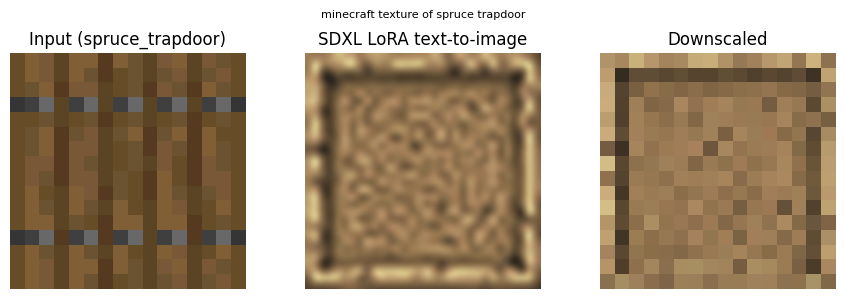


Generating text-to-image for: stone
Prompt: minecraft texture of stone


  0%|          | 0/30 [00:00<?, ?it/s]

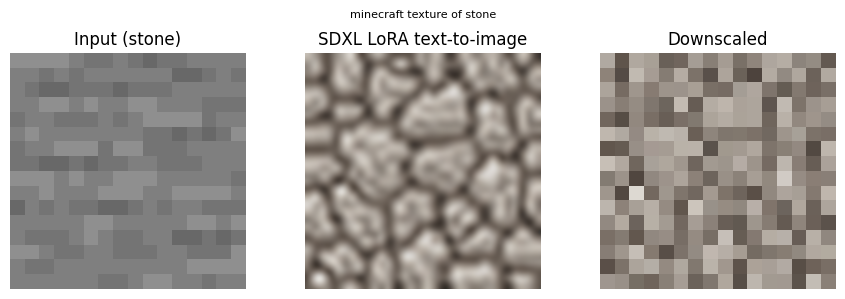


Generating text-to-image for: stone_bricks
Prompt: minecraft texture of stone bricks


  0%|          | 0/30 [00:00<?, ?it/s]

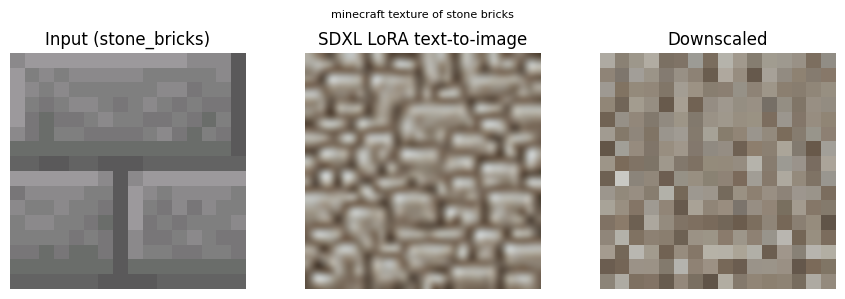

In [31]:
# SDXL LoRA text-to-image sanity check

example_ids = [850, 851, 852]
guidance_scale = 8
num_steps = 30
style_suffix = ""

for idx in example_ids:
    sample   = default_dataset[idx]
    tex_name = sample["texture_name"]
    clean    = tex_name.replace("_", " ")

    prompt = f"minecraft texture of {clean}"
    if style_suffix:
        prompt += f", {style_suffix}"

    print("\nGenerating text-to-image for:", tex_name)
    print("Prompt:", prompt)

    generator = torch.Generator(device=device).manual_seed(42) # earlier this made everything pink I dont know why this note book is different

    out_img = pipe_txt(
        prompt=prompt,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        generator=generator,
        cross_attention_kwargs={"scale": 0.5},
    ).images[0]

    orig_img = sample["image_rgb"]
    out_small = out_img.resize(orig_img.size, resample=Image.NEAREST)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(orig_img)
    axes[0].set_title(f"Input ({tex_name})")
    axes[0].axis("off")

    axes[1].imshow(out_img)
    axes[1].set_title("SDXL LoRA text-to-image")
    axes[1].axis("off")

    axes[2].imshow(out_small)
    axes[2].set_title("Downscaled")
    axes[2].axis("off")

    plt.suptitle(prompt, fontsize=8)
    plt.tight_layout()
    plt.show()



Generating text-to-image for: spruce_trapdoor
Prompt: minecraft texture of spruce trapdoor


  0%|          | 0/30 [00:00<?, ?it/s]

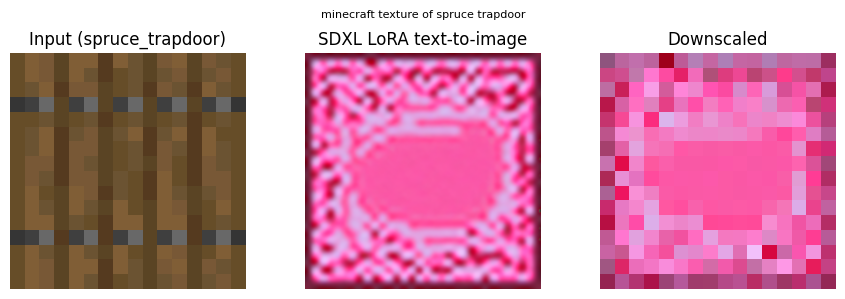


Generating text-to-image for: stone
Prompt: minecraft texture of stone


  0%|          | 0/30 [00:00<?, ?it/s]

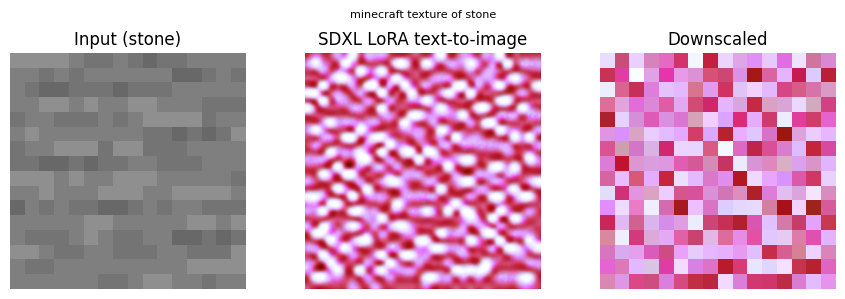


Generating text-to-image for: stone_bricks
Prompt: minecraft texture of stone bricks


  0%|          | 0/30 [00:00<?, ?it/s]

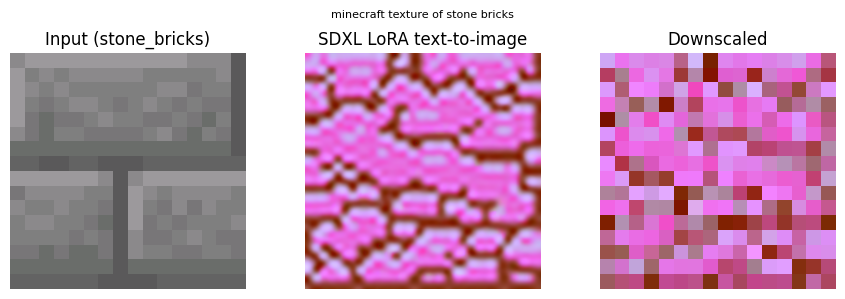

In [32]:
# SDXL LoRA text-to-image sanity check

example_ids = [850, 851, 852]
guidance_scale = 8
num_steps = 30
style_suffix = ""

for idx in example_ids:
    sample   = default_dataset[idx]
    tex_name = sample["texture_name"]
    clean    = tex_name.replace("_", " ")

    prompt = f"minecraft texture of {clean}"
    if style_suffix:
        prompt += f", {style_suffix}"

    print("\nGenerating text-to-image for:", tex_name)
    print("Prompt:", prompt)

    generator = torch.Generator(device=device).manual_seed(42) # cursed seed specific

    out_img = pipe_txt(
        prompt=prompt,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        generator=generator,
        cross_attention_kwargs={"scale": 1},
    ).images[0]

    orig_img = sample["image_rgb"]
    out_small = out_img.resize(orig_img.size, resample=Image.NEAREST)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(orig_img)
    axes[0].set_title(f"Input ({tex_name})")
    axes[0].axis("off")

    axes[1].imshow(out_img)
    axes[1].set_title("SDXL LoRA text-to-image")
    axes[1].axis("off")

    axes[2].imshow(out_small)
    axes[2].set_title("Downscaled")
    axes[2].axis("off")

    plt.suptitle(prompt, fontsize=8)
    plt.tight_layout()
    plt.show()



Generating text-to-image for: spruce_trapdoor
Prompt: minecraft texture of spruce trapdoor


  0%|          | 0/30 [00:00<?, ?it/s]

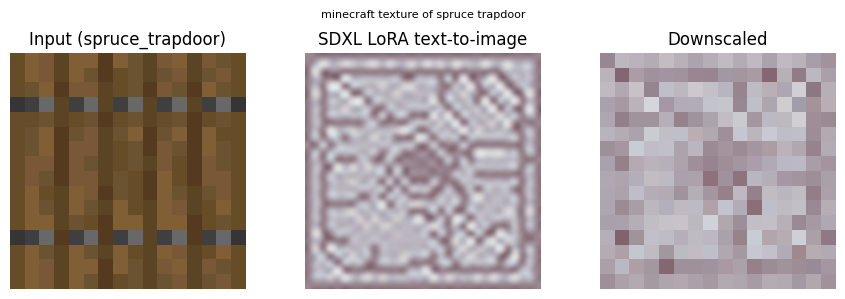


Generating text-to-image for: stone
Prompt: minecraft texture of stone


  0%|          | 0/30 [00:00<?, ?it/s]

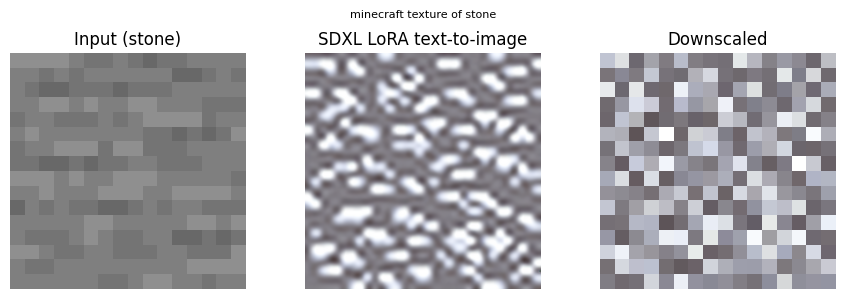


Generating text-to-image for: stone_bricks
Prompt: minecraft texture of stone bricks


  0%|          | 0/30 [00:00<?, ?it/s]

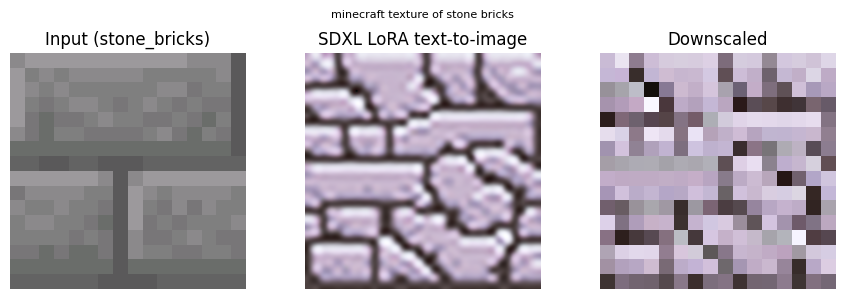

In [33]:
# SDXL LoRA text-to-image sanity check

example_ids = [850, 851, 852]
guidance_scale = 8
num_steps = 30
style_suffix = ""

for idx in example_ids:
    sample   = default_dataset[idx]
    tex_name = sample["texture_name"]
    clean    = tex_name.replace("_", " ")

    prompt = f"minecraft texture of {clean}"
    if style_suffix:
        prompt += f", {style_suffix}"

    print("\nGenerating text-to-image for:", tex_name)
    print("Prompt:", prompt)

    generator = torch.Generator(device=device).manual_seed(10) # normal

    out_img = pipe_txt(
        prompt=prompt,
        num_inference_steps=num_steps,
        guidance_scale=guidance_scale,
        generator=generator,
        cross_attention_kwargs={"scale": 1},
    ).images[0]

    orig_img = sample["image_rgb"]
    out_small = out_img.resize(orig_img.size, resample=Image.NEAREST)

    fig, axes = plt.subplots(1, 3, figsize=(9, 3))

    axes[0].imshow(orig_img)
    axes[0].set_title(f"Input ({tex_name})")
    axes[0].axis("off")

    axes[1].imshow(out_img)
    axes[1].set_title("SDXL LoRA text-to-image")
    axes[1].axis("off")

    axes[2].imshow(out_small)
    axes[2].set_title("Downscaled")
    axes[2].axis("off")

    plt.suptitle(prompt, fontsize=8)
    plt.tight_layout()
    plt.show()
